In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [118]:
age_grups_incidence = pd.read_csv("./final_dataset/age_group_incidence.csv")

/var/folders/3z/db289jnj3cdd97p1_ybqywr00000gn/T/ipykernel_52842/2205366522.py:1: DtypeWarning: Columns (9,15,16,32,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  age_grups_incidence = pd.read_csv("./final_dataset/age_group_incidence.csv")


In [119]:
age_groups = ["до 1 р.", "1-4 р.", "5-9 р.", "10-14р", "15-19р", 
              "в т.ч. 15-17р",	"20-24р",	"25-29р", "30-34р",
              "35-39р", "40-44р", "45-49р", "50-54р", "55-59р", 
              "60-64р", "65-69р",	"70-74р",	"75-79р",	"80-84р",	"85 та старші"]

age_group_df = [age_grups_incidence[age_grups_incidence["age_group"] == group] for group in age_groups]

In [120]:
man_groups_incidence = [ df[df['category_x'] == "Злоякiснi новоутворення-всього         C00-C97    ч"] for df in age_group_df ][11:]

In [121]:

def plot_regions_panel(dfs, column_name, title):
    regions = list(dfs[0]['region'].unique())
    regions.remove("м.Севастополь")
    regions.remove("м.Київ")
    fig, ax = plt.subplots(5, 5, figsize=(16, 10))

    fig.suptitle(title)

    for i, region in enumerate(regions):
        n, m = i // 5, i % 5
        for df in dfs:
            regions_ts = df[df['region'] == region]
            sns.lineplot(x=regions_ts['year'], y=regions_ts[column_name], linewidth=2.5, color='b', marker='o', markersize=5, ax=ax[n, m])
        ax[n, m].set_title(region)
        ax[n, m].set_xticks([])
        ax[n, m].set_yticks([])
        ax[n,m].set_xlabel("")  
        ax[n,m].set_ylabel("")  

    plt.show()

def plot_one_region_ts(dfs, column_name, title, region):
    plt.figure(figsize=(12, 6))

    for df in dfs:
        region_ts = df[df["region"] == region]
        print(region_ts[column_name])
        sns.lineplot(x=df['year'], y=region_ts[column_name], linewidth=2.5, color='b', marker='o', markersize=5)

    plt.title(title, fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show()


In [123]:

reduced = age_grups_incidence.drop_duplicates(subset=["year", "region"], keep="first")


13              NaN
40              NaN
67              NaN
94              NaN
121             NaN
148             NaN
175             NaN
202             NaN
229             NaN
256             NaN
283             NaN
310             NaN
337             NaN
364             NaN
391             NaN
418             NaN
445             NaN
472             NaN
499             NaN
81876      527090.0
210700     526821.0
271724     536020.0
386988     539255.0
515812     543959.0
549728     549056.0
576867     546553.0
637891     541848.0
698915     538212.0
759939     515722.0
820963     504824.0
881987     486904.0
943012     312620.0
1004037    368521.0
1065061    430681.0
1126083    521834.0
Name: nill, dtype: float64


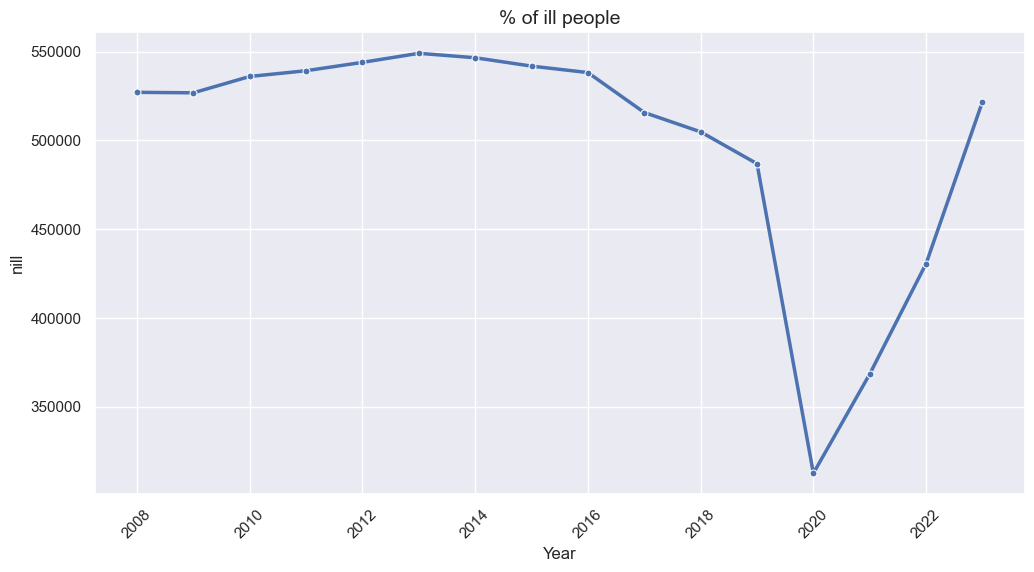

In [124]:
plot_one_region_ts([reduced], "nill", "% of ill people", "Львівська")
# plot_regions_panel([reduced], "nill", "Ill people")

drop missing gdp and cpi for now

In [125]:
age_grups_incidence = age_grups_incidence.dropna(subset=["cpi", "gdp"])

gdp_numeric = pd.to_numeric(age_grups_incidence["gdp"], errors="coerce")
mask_convertible = gdp_numeric.notna()

age_grups_incidence = age_grups_incidence[mask_convertible]

age_grups_incidence["gdp"] = age_grups_incidence.gdp.astype("float64")

age_grups_incidence["normalized_gdp"] = age_grups_incidence["gdp"]/age_grups_incidence["cpi"]

In [126]:
age_grups_incidence_no_na = age_grups_incidence.dropna()
age_grups_incidence_no_na.columns

Index(['Unnamed: 0.1', 'year', 'category_x', 'region', 'age_group',
       'incidence', 'category_y', 'nhospotal', 'nbeds', 'ybeds', 'nill',
       'nvillage_ill', 'bed_days', 'dvisits', 'hvisits', 'ndoctors',
       'nnursing', 'nx_ray', 'nflurography', 'nradiology', 'nradlab', 'nсt',
       'ncardiogram', 'ndiaglab', 'nbacter', 'nbiochem', 'ncyto', 'nimun',
       'nphysic', 'nendoscop', 'nultrasound', 'ndialysis', 'gdp', 'Unnamed: 0',
       'air_pollution', 'polluted_dumps', 'not_cleaned_dumps',
       'dumps_not_cleaned_enough', 'num_clearing_plants', 'cpi', 'population',
       'normalized_gdp'],
      dtype='object')

In [127]:
age_grups_incidence_no_na.category_y.unique()

array(['ВСЬОГО'], dtype=object)

In [ ]:
target_variable = "incidence"  # change this to your actual target variable

exclude_vars = ["Unnamed: 0.1","year", "region", "category_y"]

models = {}

for group_name, group_data in age_grups_incidence.groupby("age_group"):
    # Drop excluded columns and the target variable from predictors.
    predictors = group_data.drop(columns=exclude_vars + [target_variable], errors="ignore")
    
    if predictors.empty:
        print(f"No predictors available for age group: {group_name}")
        continue
        
    # Define predictors and target
    X = predictors.copy()
    y = group_data[target_variable]
    
    # Add constant to predictors
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    models[group_name] = model
    
    print(f"Linear Regression Summary for age group '{group_name}':\n")
    print(model.summary())
    print("\n" + "-"*80 + "\n")

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).